In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


irisデータセットでcvxoptの動きを見ておく

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#sysはコマンドライン引数
import sys
import csv
#cvxoptのインポート
import numpy as np
import cvxopt
from cvxopt import matrix
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("../../iris-dataset.csv")
df = df.drop('species', axis=1)

#クラスタ数宣言
c=5
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納

X_size,dimension = X.shape
#Kはクラスタサイズ(fecboの場合整数に限らない)
K=X_size/c
max_iter = 1
best_J = 10000

In [8]:
X.shape

(150, 4)

In [9]:
#uの最適化部分関数作成
def u_optimize(p):#距離pを引数に取り，帰属度配列Uと目的関数Jを返す関数
    #三項演算子でデータ点をクラスタ中心にしている場合、距離dを少しずらす
    p = [0.0000000001 if i == 0 else i for i in p]
    p_1 = 1/2 * np.diag(p)
    P = matrix(p_1.astype('float'))
    #--------------------
    q = matrix(np.zeros(len(p)).astype('float'))
    #--------------------
    g = [-1 for i in range(len(p))]
    G = matrix(np.diag(g).astype("float"))
    #--------------------
    h1 = np.zeros(len(p))
    h = matrix(h1)
    #--------------------
    b1 = np.ones(X_size)
    b1 = np.append(b1,[K,K,K,K])
    b = matrix(b1.astype('float'))
    #--------------------
    #A作成
    s_pre1=[]
    s_pre=[]
    for i in range(X_size):
        for j in range(X_size*c):
            if j==c*i or j==c*i+1 or j==c*i+2 or j==c*i+3 or j==c*i+4:
                s_pre1.append(1)
            else:
                s_pre1.append(0)
        s_pre.append(s_pre1)
        s_pre1=[]
    s = np.array(s_pre).astype('float')
    #---------ここまででu_ki=1---------
    a0 = np.zeros(len(p))
    a1 = np.zeros(len(p))
    a2 = np.zeros(len(p))
    a3 = np.zeros(len(p))
    #a4 = np.zeros(50)
    a0[::5]=1
    a1[1::5]=1
    a2[2::5]=1
    a3[3::5]=1
    # a4[4::5]=1←ランクが下がっちゃう
    aa = np.stack([a0,a1,a2,a3])
    # -----ここまでu_ki=Kの作成------
    a = np.concatenate([s,aa])
    A = matrix(a.astype('float'))
    #--------------------
    sol = cvxopt.solvers.qp(P,q,G=G,h=h,A=A,b=b)
    u = np.array(sol['x'])
    result = sol['primal objective']
    #print(sol)
    #print(sol['x'])
    #print(sol['primal objective'])
    
    return u,result
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([X_size,c])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**2
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**2
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**2
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**2
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**2
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**2*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**2*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**2*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**2*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**2*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

for s in range (1):
    centroids = X[np.random.choice(X_size,c)]
    for epoch in range(1):
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        optimize_result = u_optimize(d)
        u = optimize_result[0]
        J = optimize_result[1]
        #vの更新
        v = v_calculation(u)
        new_centroids = np.array(v)
        new_centroids_kai = new_centroids[::-1,]
        # もしも重心が変わっていなかったら終了
        if (np.allclose(new_centroids, centroids) or np.allclose(new_centroids_kai, centroids)):
            print("中心が変わらないのでbreakします！")
            break
        centroids =  np.copy(new_centroids)
        #print(epoch)
        #print("回目終了")
    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J:
        u_list = u.reshape([X_size,c])
        np_cluster = np.argmax(u_list,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

     pcost       dcost       gap    pres   dres
 0:  5.5703e+01 -1.6979e+02  1e+03  3e+01  5e+01
 1:  5.7807e+01 -9.5096e+01  2e+02  4e-15  8e-15
 2:  5.5885e+01  4.4188e+01  1e+01  1e-15  6e-15
 3:  5.5234e+01  5.2976e+01  2e+00  1e-15  3e-15
 4:  5.5059e+01  5.4872e+01  2e-01  1e-15  3e-15
 5:  5.5039e+01  5.5030e+01  9e-03  1e-15  4e-15
 6:  5.5038e+01  5.5038e+01  4e-04  1e-15  3e-15
 7:  5.5038e+01  5.5038e+01  2e-05  1e-14  3e-15
Optimal solution found.
0
回目のクラスタリング結果↓
55.03791490158014
[[5.50764211 3.22362397 2.62166951 0.7187021 ]
 [5.52556336 3.37637278 2.71053165 0.78522882]
 [6.96928735 3.08916271 5.83422358 2.05266301]
 [5.05128936 3.03371309 2.3427435  0.60358769]
 [5.32313543 2.9878601  2.85928269 0.77837931]]
終了
[0 3 3 3 1 1 3 0 3 4 1 4 3 3 1 1 1 0 1 1 0 1 3 0 4 4 1 0 0 4 4 0 1 1 4 0 0
 4 3 0 0 3 3 1 1 3 1 3 1 0 2 1 2 4 1 4 2 4 1 4 4 1 4 1 4 1 4 4 4 4 2 1 2 4
 1 1 2 2 1 4 4 4 4 2 4 1 2 4 4 4 4 1 4 4 4 4 4 1 4 4 2 2 2 2 2 2 4 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [17]:
answer = u_optimize(d)
print(answer)

     pcost       dcost       gap    pres   dres
 0:  5.5703e+01 -1.6979e+02  1e+03  3e+01  5e+01
 1:  5.7807e+01 -9.5096e+01  2e+02  4e-15  8e-15
 2:  5.5885e+01  4.4188e+01  1e+01  1e-15  6e-15
 3:  5.5234e+01  5.2976e+01  2e+00  1e-15  3e-15
 4:  5.5059e+01  5.4872e+01  2e-01  1e-15  3e-15
 5:  5.5039e+01  5.5030e+01  9e-03  1e-15  4e-15
 6:  5.5038e+01  5.5038e+01  4e-04  1e-15  3e-15
 7:  5.5038e+01  5.5038e+01  2e-05  1e-14  3e-15
Optimal solution found.
(array([[6.55750614e-01],
       [1.62035648e-01],
       [3.10224290e-09],
       [9.40215564e-02],
       [8.81921787e-02],
       [1.37677964e-01],
       [6.18758008e-02],
       [3.19813959e-09],
       [4.09780925e-01],
       [3.90665307e-01],
       [2.27486427e-03],
       [3.42559175e-03],
       [3.12396388e-09],
       [8.71623493e-01],
       [1.22676048e-01],
       [7.17469871e-04],
       [1.35741235e-03],
       [3.10763365e-09],
       [7.26588656e-01],
       [2.71336459e-01],
       [3.28676903e-01],
       [3.

In [28]:
answer = u_optimize(d)
print(answer)
u_list = answer[0].reshape([X_size,c])
print("帰属度とクラスタサイズの確認")
print(u_list.shape)
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
(150, 5)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[30. 30. 30. 30. 30.]


array([[6.55750614e-01, 1.62035648e-01, 3.10224290e-09, 9.40215564e-02,
        8.81921787e-02],
       [1.37677964e-01, 6.18758008e-02, 3.19813959e-09, 4.09780925e-01,
        3.90665307e-01],
       [2.27486427e-03, 3.42559175e-03, 3.12396388e-09, 8.71623493e-01,
        1.22676048e-01],
       [7.17469871e-04, 1.35741235e-03, 3.10763365e-09, 7.26588656e-01,
        2.71336459e-01],
       [3.28676903e-01, 3.96604345e-01, 3.13738246e-09, 1.41082141e-01,
        1.33636608e-01],
       [2.28959065e-01, 5.74299734e-01, 3.35144426e-09, 9.12817260e-02,
        1.05459471e-01],
       [3.76570945e-02, 4.27783806e-02, 3.15905349e-09, 6.55654202e-01,
        2.63910320e-01],
       [4.15256145e-01, 1.58792820e-01, 3.13374825e-09, 1.88642415e-01,
        2.37308617e-01],
       [6.30329633e-02, 4.87862007e-02, 3.27112220e-09, 5.76547036e-01,
        3.11633797e-01],
       [1.11581432e-01, 4.85412662e-02, 3.16929172e-09, 3.43068931e-01,
        4.96808368e-01],
       [3.93174188e-01, 4.3471

In [24]:
#u = np.array(sol['x'])
#u_list = u.reshape([X_size,c])
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[20. 20. 20. 20. 20.]


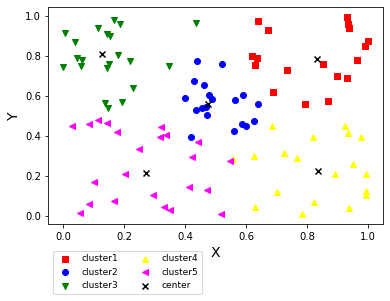

In [29]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示
plt.show()

fig.savefig("ransuu_nizikeikakuhou.pdf",bbox_inches='tight')

In [ ]:
fig = plt.figure()
fig.savefig("ransuu_nizikeikakuhou.pdf",bbox_inches='tight')

4を0
0を4

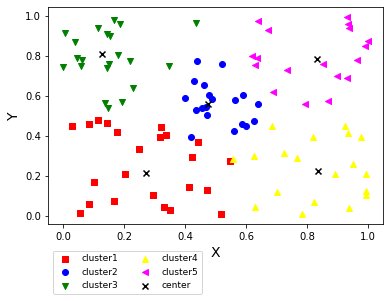

In [32]:
np_cluster_kai = np.where(np_cluster==0, 100, np_cluster)
np_cluster_kai1 = np.where(np_cluster_kai==4, 0, np_cluster_kai)
np_cluster_kai2 = np.where(np_cluster_kai1==100, 4, np_cluster_kai1)
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster_kai2==i], X[:, 1][np_cluster_kai2==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示
plt.show()

fig.savefig("ransuu_nizikeikakuhou.pdf",bbox_inches='tight')

In [33]:
print(np.count_nonzero(np_cluster_kai2==0))
print(np.count_nonzero(np_cluster_kai2==1))
print(np.count_nonzero(np_cluster_kai2==2))
print(np.count_nonzero(np_cluster_kai2==3))
print(np.count_nonzero(np_cluster_kai2==4))

23
19
21
19
18


ここまでが完成コード

二次計画法

In [33]:
#pにはd11,d12,d13,,,,d21,d22,,,dn1,,dncの順でリスト作る
p=[]
for i in range(X_size):
    for j in range(c):
        p.append(np.sum((X[i]-centroids[j])**2))
#三項演算子でデータ点をクラスタ中心にしている場合、距離dを少しずらす
p = [0.0000000001 if i == 0 else i for i in p]
p_1 = 1/2 * np.diag(p)
P = matrix(p_1.astype('float'))
#--------------------
q = matrix(np.zeros(len(p)).astype('float'))
#--------------------
g = [-1 for i in range(len(p))]
G = matrix(np.diag(g).astype("float"))
#--------------------
h1 = np.zeros(len(p))
h = matrix(h1)
#--------------------
b1 = np.ones(X_size)
b1 = np.append(b1,[K,K,K,K])
b = matrix(b1.astype('float'))
#--------------------
#A作成
s_pre1=[]
s_pre=[]
for i in range(X_size):
    for j in range(X_size*c):
        if j==c*i or j==c*i+1 or j==c*i+2 or j==c*i+3 or j==c*i+4:
            s_pre1.append(1)
        else:
            s_pre1.append(0)
    s_pre.append(s_pre1)
    s_pre1=[]
s = np.array(s_pre).astype('float')
#---------ここまででu_ki=1---------
a0 = np.zeros(len(p))
a1 = np.zeros(len(p))
a2 = np.zeros(len(p))
a3 = np.zeros(len(p))
#a4 = np.zeros(50)
a0[::5]=1
a1[1::5]=1
a2[2::5]=1
a3[3::5]=1
# a4[4::5]=1
aa = np.stack([a0,a1,a2,a3])
# -----ここまでu_ki=Kの作成------
a = np.concatenate([s,aa])
A = matrix(a.astype('float'))
#--------------------
sol = cvxopt.solvers.qp(P,q,G=G,h=h,A=A,b=b)
#print(sol)
#print(sol['x'])
result = sol['primal objective']
print(sol['primal objective'])
print(result)

     pcost       dcost       gap    pres   dres
 0:  3.3740e-01 -9.9374e+01  1e+02  2e-16  3e+01
 1:  3.3550e-01 -1.3472e+00  2e+00  8e-16  5e-01
 2:  2.8506e-01 -4.3340e-02  3e-01  8e-16  7e-02
 3:  2.4260e-01  1.9155e-01  5e-02  9e-16  5e-03
 4:  2.3545e-01  2.2519e-01  1e-02  9e-16  8e-04
 5:  2.3381e-01  2.3302e-01  8e-04  1e-15  2e-05
 6:  2.3366e-01  2.3361e-01  5e-05  1e-15  3e-07
 7:  2.3364e-01  2.3364e-01  3e-06  2e-15  2e-09
 8:  2.3364e-01  2.3364e-01  2e-07  2e-14  3e-11
Optimal solution found.
0.23364151870212438
0.23364151870212438


In [3]:
np_cluster

NameError: name 'np_cluster' is not defined

In [3]:
#pにはd11,d12,d13,,,,d21,d22,,,dn1,,dncの順でリスト作る
p=[]
for i in range(X_size):
    for j in range(c):
        p.append(np.sum((X[i]-centroids[j])**2))
#三項演算子でデータ点をクラスタ中心にしている場合、距離dを少しずらす
p = [0.0000000001 if i == 0 else i for i in p]
print(p)

[0.037320282777999994, 0.04566250000000001, 0.03592027277799999, 0.04128403888900001, 0.0007360988890000023, 0.06765348277799996, 0.07666250000000001, 0.15158707277799996, 0.07461723888899999, 0.033402898888999964, 0.08698708277800002, 0.0946625, 0.0002534727780000004, 0.08795083888900002, 0.04806929888900002, 0.15398708277799994, 0.0006625000000000001, 0.07125347277799998, 0.0002840388889999999, 0.032736098888999976, 0.000653482778000003, 0.17066250000000002, 0.08058707277799998, 0.162284038889, 0.04873609888900001, 0.044836954444999993, 0.037073613889, 0.04312568888900001, 0.033309025555999995, 1e-10, 0.042911952778, 0.0391625, 0.03967860277799999, 0.035200698889, 9.443888900000061e-05, 0.03150152777799999, 0.05395625000000001, 0.03295152777799999, 0.04911112888900001, 0.0022090088890000057, 0.040350718888999985, 0.04393624888900002, 0.031245264444999987, 0.03952862277800002, 0.0011513777780000046, 0.045181249999999985, 0.03674734777800001, 0.04348707111200001, 0.03300914888900001, 1

In [4]:
len(p)

495

In [5]:
p_1 = 1/2 * np.diag(p)
P = matrix(p_1.astype('float'))
P

<495x495 matrix, tc='d'>

In [6]:
q = matrix(np.zeros(len(p)).astype('float'))
q

<495x1 matrix, tc='d'>

In [7]:
g = [-1 for i in range(len(p))]
G = matrix(np.diag(g).astype("float"))
G

<495x495 matrix, tc='d'>

In [8]:
h1 = np.zeros(len(p))
h = matrix(h1)
h

<495x1 matrix, tc='d'>

In [ ]:
for i in 

In [9]:
b1 = np.ones(X_size)
b1 = np.append(b1,[K,K,K,K])
b = matrix(b1.astype('float'))
b

<103x1 matrix, tc='d'>

In [10]:
b1

array([ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,
       19.8, 19.8, 19.8, 19.8])

In [11]:
#A作成
s_pre1=[]
s_pre=[]
for i in range(X_size):
    for j in range(X_size*c):
        if j==c*i or j==c*i+1 or j==c*i+2 or j==c*i+3 or j==c*i+4:
            s_pre1.append(1)
        else:
            s_pre1.append(0)
    s_pre.append(s_pre1)
    s_pre1=[]
s = np.array(s_pre).astype('float')
#---------ここまででu_ki=1---------
a0 = np.zeros(len(p))
a1 = np.zeros(len(p))
a2 = np.zeros(len(p))
a3 = np.zeros(len(p))
#a4 = np.zeros(50)
a0[::5]=1
a1[1::5]=1
a2[2::5]=1
a3[3::5]=1
# a4[4::5]=1
aa = np.stack([a0,a1,a2,a3])
# -----ここまでu_ki=Kの作成------
a = np.concatenate([s,aa])
A = matrix(a.astype('float'))

In [13]:
a.shape

(103, 495)

In [41]:
#Aのランクがない
np.linalg.matrix_rank(A)

103